In [233]:
#####---Workspace setup and data pre-processing---######

#Import all required packages.

#Core packages
from pathlib import Path
import pandas as pd
import numpy as np

#Data pre-processing packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

#Visualisation packages
import seaborn as sns
import matplotlib.pyplot as plt
import umap

#Statistics packages
from statsmodels.stats.multitest import multipletests 
from scipy.stats import ttest_ind 

#Modelling packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [234]:
#sets the current working directory to where the file is located.
BASE_DIR = Path.cwd()
data_path = BASE_DIR / "camp2_logcounts.csv"

#read in the data.
brain = pd.read_csv(data_path)

In [235]:
#Transform the data so that the columns are the different genes, and the rows are the samples.
brain_t = brain.set_index(brain.columns[0]).T
#Fixes the name of the samples column.
brain_t.reset_index(inplace=True)
brain_t.rename(columns={'index': 'Sample'}, inplace=True)

In [236]:
#method to define the different sample type as per camp et al. 2015. 
#horg= human organoid. 
#ESC/iPSC- represents human organoid cortex region cells that were microdissected on day 53 (ESC) or day 58 (iPSC)
#horg 33-65 = cells from whole iPSC organoids, at various ages.
#fetal- fetal brain cells at week 12 or 13.

def cell_type(Sample):
    if 'horg' in Sample.lower() and 'esc' in Sample.lower():
        return 'horg_ESC_cortex'
    elif 'horg' in Sample.lower() and 'ipsc' in Sample.lower():
        return 'horg_iPSC_cortex'
    elif 'horg' in Sample.lower() and '33d' in Sample.lower():
        return 'horg_33'
    elif 'horg' in Sample.lower() and '35d' in Sample.lower():
        return 'horg_35'
    elif 'horg' in Sample.lower() and '37d' in Sample.lower():
        return 'horg_37'
    elif 'horg' in Sample.lower() and '41d' in Sample.lower():
        return 'horg_41'
    elif 'horg' in Sample.lower() and '65d' in Sample.lower():
        return 'horg_65'
    elif 'fetal' in Sample.lower() and '12wpc' in Sample.lower():
        return 'fetal_12'
    elif 'fetal' in Sample.lower() and '13wpc' in Sample.lower():
        return 'fetal_13'     
    else:
        return 'Other'

#Apply the algorithm to the dataset in a new column.
brain_t['Type'] = brain_t['Sample'].apply(cell_type)

In [237]:
#Method to define age of whole organoid cells (in days). Returns all other samples as 'NaN' for further separation.
def age(Sample):
    if 'horg' in Sample.lower() and '33d' in Sample.lower():
        return int(33)
    elif 'horg' in Sample.lower() and '35d' in Sample.lower():
        return int(35)
    elif 'horg' in Sample.lower() and '37d' in Sample.lower():
        return int(37)
    elif 'horg' in Sample.lower() and '41d' in Sample.lower():
        return int(41)
    elif 'horg' in Sample.lower() and '65d' in Sample.lower():
        return int(65)
    else:
        return np.nan
#Adds age of organoids to a new column in the dataset.
brain_t['Age'] = brain_t['Sample'].apply(age)

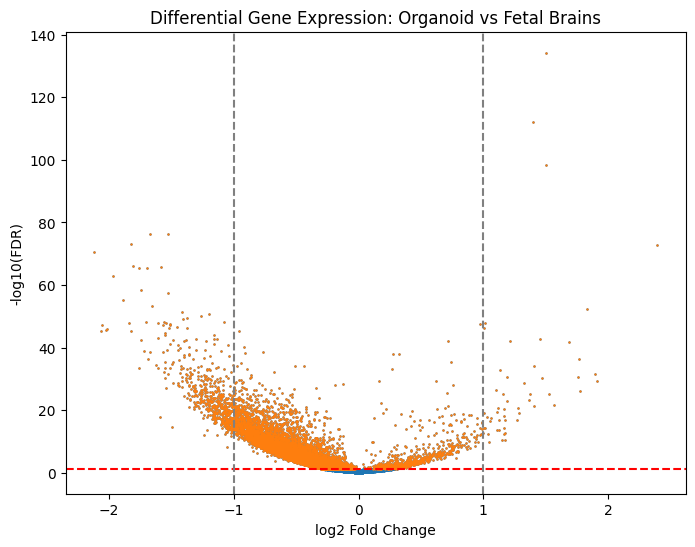

In [238]:
###----Visualisation----###

#Visualise overall differential gene expression between organoids and fetal brains using a volcano plot

#Define/group gene names.
genes = brain_t.drop(columns=["Sample","Age","Type"]).columns 

#Subsetting the data to only include whole organoid samples with a defined age. 
brain_t_organoids = brain_t.dropna(subset=["Age"])

#define fetal and organoid variables, and make all the data numerical. 
results = [] 
Organoid_X = brain_t_organoids.drop(columns=['Type','Age','Sample'])
brain_t_fetal = brain_t.loc[brain_t["Type"].isin(["fetal_12", "fetal_13"])].copy()
fetal_X = brain_t_fetal.drop(columns=['Type','Age','Sample'])

#Create a dataframe with the log fold change(LFC) in gene expression between organoids and fetal brains.
for gene in genes: 
    g1 = Organoid_X[gene].values 
    g2 = fetal_X[gene].values 
    t, p = ttest_ind(g1, g2, equal_var=False)  #T-test to determine significance of log fold change (p)
    lfc = np.log2(np.mean(g2) + 1) - np.log2(np.mean(g1) + 1) 
    results.append([gene, lfc, p]) 
 
dge = pd.DataFrame(results, columns=["gene", "log2FC", "pvalue"]) 

# Remove rows where p-values are NaN.
dge = dge.dropna(subset=["pvalue"]).copy()

#Correct p-value to reduce false positives using Benjamini–Hochberg.
dge["FDR"] = multipletests(dge["pvalue"], method="fdr_bh")[1] 
deg = dge.sort_values("FDR").query("FDR < 0.05") 

# Highlight genes with a significant adjusted p-value (p<0.05)
sig = dge[dge["FDR"] < 0.05] 

# Make the volcano plot.
plt.figure(figsize=(8,6)) 

plt.scatter(dge["log2FC"], -np.log10(dge["FDR"]), alpha=1, s=0.5) 
plt.scatter(sig["log2FC"], -np.log10(sig["FDR"]), alpha=1, s=0.5) 

plt.axhline(-np.log10(0.05), color='red', linestyle='--') 
plt.axvline(1, color='grey', linestyle='--') 
plt.axvline(-1, color='grey', linestyle='--') 

plt.xlabel("log2 Fold Change") 
plt.ylabel("-log10(FDR)") 
plt.title("Differential Gene Expression: Organoid vs Fetal Brains") 
plt.show() 

C:\Users\c25030664\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


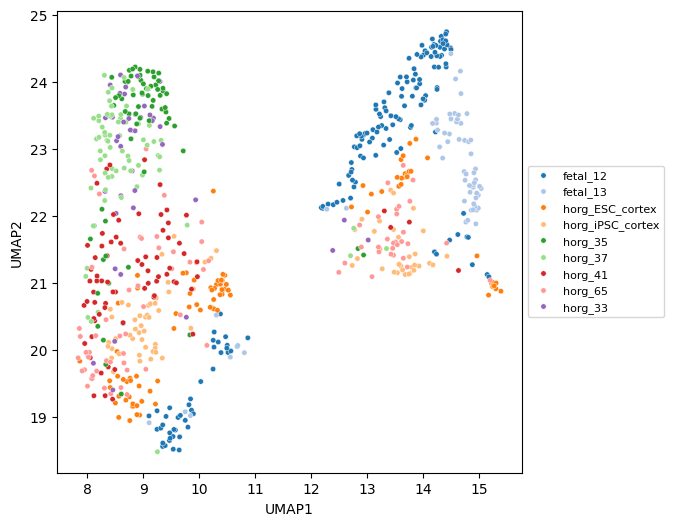

In [239]:
#Visualisation of the data as a umap

#Make the X variable completely numerical for scaling.
brain_X = brain_t.drop(columns=['Type','Age','Sample'])

#Scales the data as this is required for umap.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(brain_X)

#PCA transformation of the data. This reduces noise as it is a large and variable dataset. 
pca = PCA(n_components=100)
x_pca = pca.fit_transform(X_scaled)

#Set the umap parameters.These parameters can be altered based on the dataset.
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    init='pca',
)

#Embedding the data into the umap parameters that it can fit into a 2D space.
embedding = reducer.fit_transform(x_pca)

#Creating a dataframe with the created UMAP values and sample types. This allows for easier plotting.
brain_umap= pd.DataFrame({
    "UMAP1": embedding[:,0],
    "UMAP2": embedding[:,1],
    "CellType": brain_t['Type']
})

#Plot the umap data, colouring by Cell type.
plt.figure(figsize=(6,6))
sns.scatterplot(data=brain_umap, x="UMAP1", y="UMAP2", hue="CellType", s=15, palette="tab20", legend="full")
legend=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 8})
plt.show()

In [240]:
####----Building a model to predict organoid age----####

#Setting X and y variables, where X is all genes in the transcriptome, and y is organoid age. 
X = Organoid_X
y = brain_t_organoids["Age"]

#Train the random forest regression model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

#Predict values using the model to test accuracy.
y_pred = rf.predict(X_test)

#Print the scoring to determine accuracy.
print("R2 score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.9240408997288843
MSE: 12.981916179104477


In [241]:
###---Improve the model via feature importance---####

#report importances.
importances = rf.feature_importances_
gene_names = X.columns

# Put the importance values into a dataframe with the gene names.
gene_importance_df = pd.DataFrame({
    "feature": gene_names,
    "importance": importances
})

# Sort and print top 10 genes that contribute to the model.
top10 = gene_importance_df.sort_values(by="importance", ascending=False).head(10)
print(top10)

         feature  importance
10455     NDUFA3    0.545170
17299       TUBB    0.362352
10313      NACA2    0.028993
10121  MTRNR2L12    0.009447
4206      DDX39B    0.006192
4805      EEF1A1    0.002051
7276     HNRNPA1    0.001982
7277   HNRNPA1L2    0.001895
3525      COMMD6    0.001660
12641    PPP1R10    0.001619


In [242]:
#Re-run the model with just the most important features.
X2 = Organoid_X[['NDUFA3','TUBB','NACA2','MTRNR2L12']]

#Train the random forest regression model.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

rf.fit(X_train2, y_train2)

#Predict values using the model to test accuracy.
y_pred2 = rf.predict(X_test2)

#Print the scoring to determine accuracy.
print("R2 score:", r2_score(y_test2, y_pred2))
print("MSE:", mean_squared_error(y_test2, y_pred2))

R2 score: 0.9643158279457769
MSE: 6.098662686567166


In [243]:
model_accuracy = []

model_accuracy.append({
    "model": "RandomForest_full",
    "R2": r2_score(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred)
})

model_accuracy.append({
    "model": "RandomForest_optimized",
    "R2": r2_score(y_test2, y_pred2),
    "MSE": mean_squared_error(y_test2, y_pred2),
})
# Create DataFrame
model_accuracy_df = pd.DataFrame(model_accuracy).set_index("model")
print(model_accuracy_df)

                              R2        MSE
model                                      
RandomForest_full       0.924041  12.981916
RandomForest_optimized  0.964316   6.098663


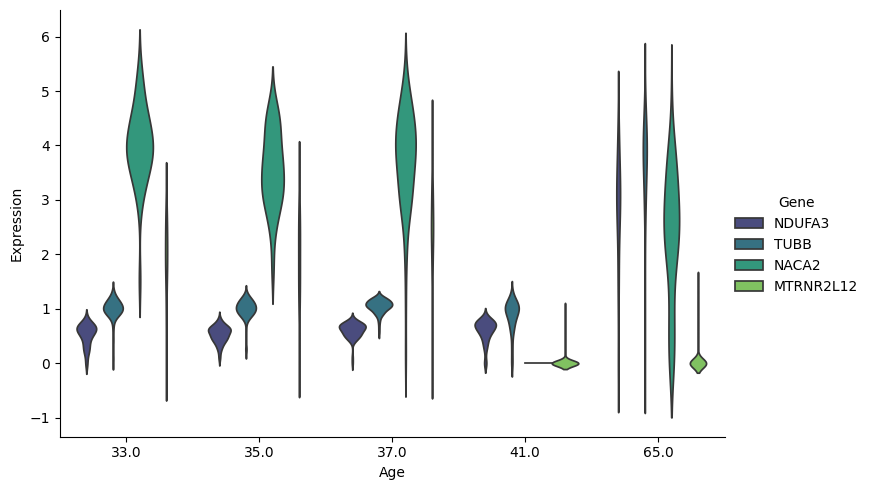

In [246]:
#Optionally- plot the top genes in the model.
brain_t_organoids_sig = brain_t_organoids[['Age','NDUFA3','TUBB','NACA2','MTRNR2L12']]

#convert the dataframe to long form for easier plotting.
organoids_sig_melt = brain_t_organoids_sig.melt(
    id_vars="Age",
    var_name="Gene",
    value_name="Expression"
)

#produce a violin plot.
sns.catplot(
    data= organoids_sig_melt,
    x="Age",
    y="Expression",
    hue = "Gene",
    kind = "violin",
    inner = None,
    aspect = 1.5,
    palette = "viridis",
)

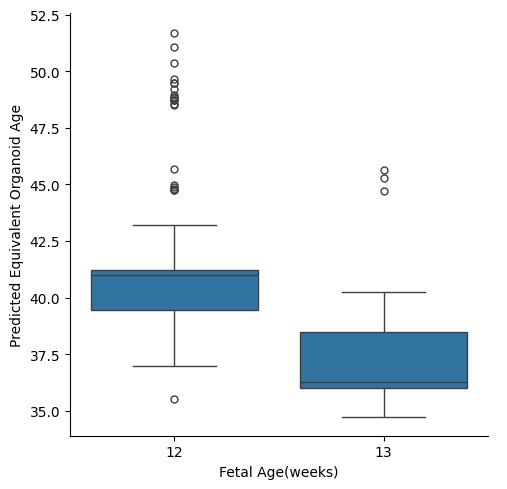

In [245]:
###---Input fetal data into the model to determine the equivalent organoid age---###
fetal_X = brain_t_fetal.drop(columns=['Type','Age','Sample'])
brain_t_fetal["predicted_age"] = rf.predict(fetal_X[['NDUFA3','TUBB','NACA2','MTRNR2L12']])

#Add a column to fetal data to include just the age in weeks for clearer plots. 
def fetal_age(Type):
    if '12' in Type:
        return int(12)
    if '13'  in Type:
        return int(13)
    else:
        return np.nan


brain_t_fetal['Age_wks'] = brain_t_fetal['Type'].apply(fetal_age)

#plot the predicted ages.
pred_fetal_age_plot = sns.catplot(data= brain_t_fetal,
                                  x="Age_wks", 
                                  y="predicted_age", 
                                  kind="box",
                                 )

pred_fetal_age_plot.set(xlabel='Fetal Age(weeks)', ylabel='Predicted Equivalent Organoid Age')
plt.show()